In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as K
import tensorflow.keras.layers as L
from datagenerator import *
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output

In [2]:
# constants:
SIZE = 160 # todo: change from 160
RESIZED_WIDTH = SIZE  # temp
RESIZED_HEIGHT = SIZE  # temp
RESIZED_NUM_PIXELS = RESIZED_WIDTH * RESIZED_HEIGHT
SHAPE = RESIZED_NUM_PIXELS + 3
TRAIN_PATH = r'R:\domain_lab\runs_processed\train'  # temp
VALID_PATH = r'R:\domain_lab\runs_processed\validation'  # temp
TEST_PATH = r'R:\domain_lab\runs_processed\test'  # temp

BACH_SIZE = 1 # temp
TRAIN_DATASET_SIZE = dataset_size(TRAIN_PATH)
VALID_DATASET_SIZE = dataset_size(VALID_PATH)
TEST_DATA_SIZE = dataset_size(TEST_PATH)
STEPS_PER_EPOCH = TRAIN_DATASET_SIZE // BACH_SIZE
EPOCHS = 1 # temp
VALIDATION_STEPS = VALID_DATASET_SIZE // BACH_SIZE
TEST_STEPS = TEST_DATA_SIZE // BACH_SIZE
IMAGE_SHAPE = (RESIZED_WIDTH, RESIZED_HEIGHT, 1)

foo = data_generator_for_cnn
a=500
bx=100
by=200
train_generator = foo(TRAIN_PATH, BACH_SIZE, True, RESIZED_WIDTH, RESIZED_HEIGHT, crop= [[a+bx,-a+bx],[a+by,-a+by]])
validation_generator = foo(VALID_PATH, BACH_SIZE, True, RESIZED_WIDTH, RESIZED_HEIGHT, crop= [[a+bx,-a+bx],[a+by,-a+by]])
test_generator = foo(TEST_PATH, BACH_SIZE, True, RESIZED_WIDTH, RESIZED_HEIGHT, crop= [[a+bx,-a+bx],[a+by,-a+by]])

class WeightsSaver(Callback):
    global test_generator
    def __init__(self, N):
        self.N = N
        self.batch = 0

    def testfunc(self,train_generator):
        clear_output(wait=True)
        c=next(train_generator)
        a,b=c[0][0],c[0][1]
        r=c[1]

        with tf.device("/CPU:0"):
            p=model([a,b])

        for i in range(1):
            plt.figure()
            plt.imshow(r[i,:].reshape((SIZE,SIZE)))
            plt.title("real")
            plt.pause(0.001)
            plt.figure()
            plt.imshow(p[i,:].numpy().reshape((SIZE,SIZE)))
            plt.title("predicted")
            plt.pause(0.001)


    def on_batch_end(self, batch, logs={}):
        if self.batch % self.N == 0:
            self.testfunc(test_generator)

def my_loss(y_true,y_pred):
    '''GAN loss function'''
    sum_loss = K.backend.abs(K.backend.sum(y_true, axis=1) - K.backend.sum(y_pred, axis=1))
    if K.backend.abs(K.backend.sum(y_true, axis=1) - K.backend.sum(y_pred, axis=1)) > 0:
        color = K.backend.abs(K.backend.sum(y_true, axis=1) - K.backend.sum(y_pred, axis=1))
    else:
        color = 0
    return 100*tf.math.reduce_mean(tf.math.abs(y_true-y_pred)) + 0*sum_loss
print('ok')

ok


In [3]:
with tf.device("/CPU:0"):
    image=L.Input(shape=IMAGE_SHAPE, name = 'image')
    voltage_data=L.Input(shape=(3,), name = 'voltage_data')

    # conv branch

    x = L.Conv2D(
        filters=64,
        kernel_size=(5, 5),
        padding="same",
        activation="relu",
    )(image)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding="same",
        activation="relu",
    )(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(
        filters=64,
        kernel_size=(1, 1),
        padding="same",
        activation="relu",
    )(x)
    x = L.BatchNormalization()(x)

    conv_flat = L.Flatten()(x)
    conv_out = L.Concatenate(axis=1)([conv_flat,voltage_data])
    flat_hidden = L.Dense(units=100, activation="sigmoid")(conv_out)
    flat_hidden = L.Dense(units=100, activation="sigmoid")(flat_hidden)
    flat_out = L.Dense(units=100, activation="sigmoid")(flat_hidden)
    # comb
    comb_out = L.Dense(units=RESIZED_NUM_PIXELS, activation="sigmoid")(flat_out) #TODO: try a step function insted of sigmoid

    # conv branch
    model = K.Model(inputs=[image,voltage_data] , outputs=comb_out)

    model.summary()

    model.compile(optimizer='adam',
                  loss=my_loss,
                  metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 160, 160, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 160, 64) 1664        image[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 160, 160, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 160, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

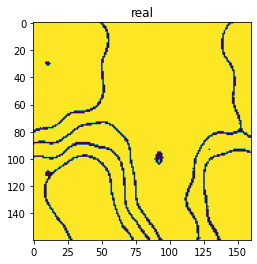

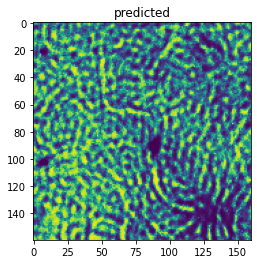

   175/224942 [..............................] - ETA: 87:22:23 - loss: 49.5722 - accuracy: 0.0000e+00

In [ ]:
with tf.device("/CPU:0"):
    model.fit(x=train_generator,
              steps_per_epoch=STEPS_PER_EPOCH,
              epochs=EPOCHS,
              validation_data=validation_generator,
              validation_steps=VALIDATION_STEPS,callbacks=[WeightsSaver(10)])